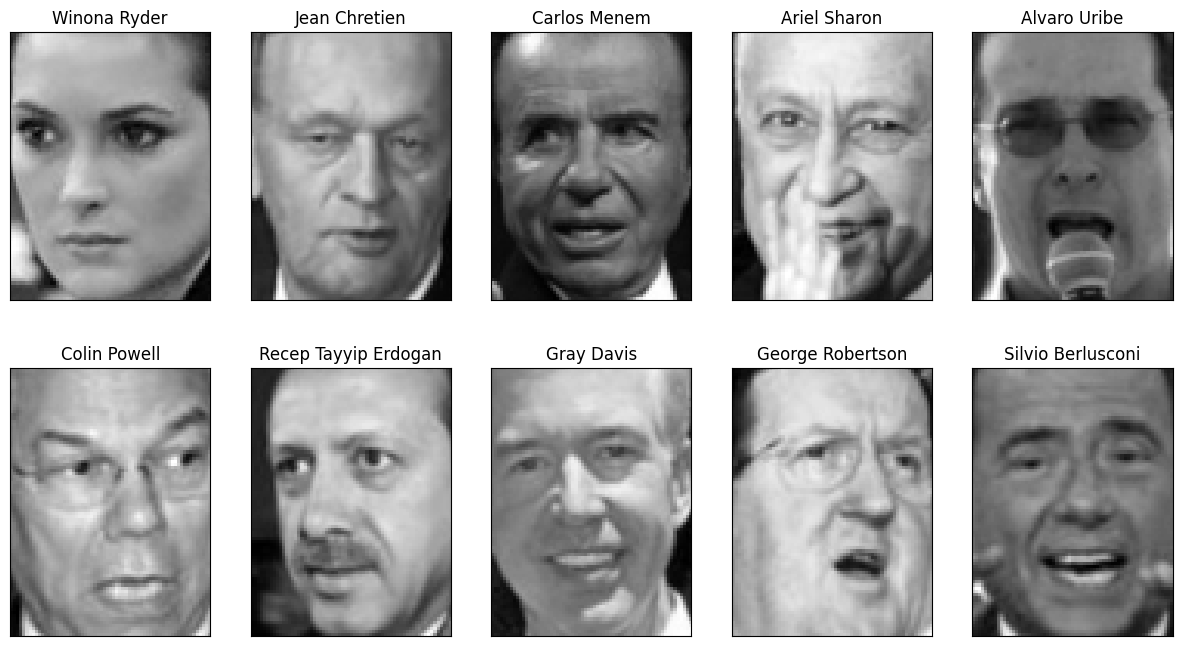

In [1]:
from sklearn.datasets import fetch_lfw_people 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7) 
image_shape = people.images[0].shape
fig , axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': () , 'yticks': ()})
for target , image, ax in zip(people.target , people.images, axes.ravel()): 
    ax.imshow(image, cmap=cm.gray)
    ax.set_title(people.target_names[target])


In [2]:
print ("people.images.shape : {}".format(people.images.shape)) 
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape : (3023, 87, 65)
Number of classes: 62


In [3]:
import numpy as np
# count how often each target appears 
counts = np.bincount(people.target)
# print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)): 
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print ()


Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Angelina Jolie             20 Ariel Sharon               77 
Arnold Schwarzenegger      42 Atal Bihari Vajpayee       24 Bill Clinton               29 
Carlos Menem               21 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Guillermo Coria            30 Hamid Karzai               22 Hans Blix                  39 
Hugo Chavez                71 Igor Ivanov                20 Jack Straw                 28 
Jacques Chirac             52 Jean Chretien              55 Jennifer Aniston           21 
Jennifer Capriati          42 Jennifer Lopez             21 Jeremy Greenstock          24 
Jiang Zemin                20 John Ashcroft              53 John Negroponte            31 

In [4]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
mask = np.zeros(people.target.shape, dtype=bool) 
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask]
y_people = people.target[mask]
X_people = X_people/255

X_train, X_test, y_train, y_test = train_test_split(X_people , y_people , stratify=y_people , random_state=0)
knn = KNeighborsClassifier(n_neighbors=1) 
knn.fit(X_train, y_train)
print("Test set score of 1−nn: {:.2f}".format(knn.score(X_test, y_test)))


Test set score of 1−nn: 0.22


In [5]:
def knn_ssd(X_train, y_train, X_test):
    dist = np.sum((X_train - x_test)**2, axis=1)
    closest_idx = np.argmin(dist)
    return y_train[closest_idx]

my_knn = np.zeros_like(y_test)
for i, x_test in enumerate(X_test):
    my_knn[i] = knn_ssd(X_train, y_train, x_test)

print("Accuracy of my KNN: {:.2f}".format(np.mean(my_knn == y_test)))

Accuracy of my KNN: 0.22


In [7]:
X_train_std = (X_train - np.mean(X_train, axis=0))/np.std(X_train, axis=0)
X_test_std = (X_test - np.mean(X_test, axis=0))/np.std(X_test, axis=0)

cov_mat = np.cov(X_train_std.T)
eig_vals, eig_vecs = np.linalg.eigh(cov_mat)

sort_indices = np.argsort(eig_vals)[::-1]
eigenvalues = eig_vals[sort_indices]
eigenvectors = eig_vecs[:, sort_indices]

W_100d = eigenvectors[:, :100]
X_train_pca = X_train_std.dot(W_100d)

knn_100d = KNeighborsClassifier(n_neighbors=1)
knn_100d.fit(X_train_pca, y_train)
X_test_pca = X_test_std.dot(W_100d)
accuracy_100d = knn_100d.score(X_test_pca, y_test)
print("Test set score of 1-nn with 100D data: {:.2f}".format(accuracy_100d))

Test set score of 1-nn with 100D data: 0.24


In [8]:
epsilon = 1e-5
X_train_whiten = (X_train - np.mean(X_train, axis=0))/(np.std(X_train, axis=0) + epsilon)
X_test_whiten = (X_test - np.mean(X_test, axis=0))/(np.std(X_test, axis=0) + epsilon)

cov_mat = np.cov(X_train_whiten.T)
eig_vals, eig_vecs = np.linalg.eigh(cov_mat)

sort_indices = np.argsort(eig_vals)[::-1]
eigenvalues = eig_vals[sort_indices]
eigenvectors = eig_vecs[:, sort_indices]

W_100d_whiten = eigenvectors[:, :100]
X_train_pca = X_train_whiten.dot(W_100d_whiten)

knn_100d_whiten = KNeighborsClassifier(n_neighbors=1)
knn_100d_whiten.fit(X_train_pca, y_train)
X_test_pca = X_test_whiten.dot(W_100d_whiten)
accuracy_100d_whiten = knn_100d_whiten.score(X_test_pca, y_test)
print("Test set score of 1-nn with 100D whitened data: {:.2f}".format(accuracy_100d_whiten))


Test set score of 1-nn with 100D whitened data: 0.24


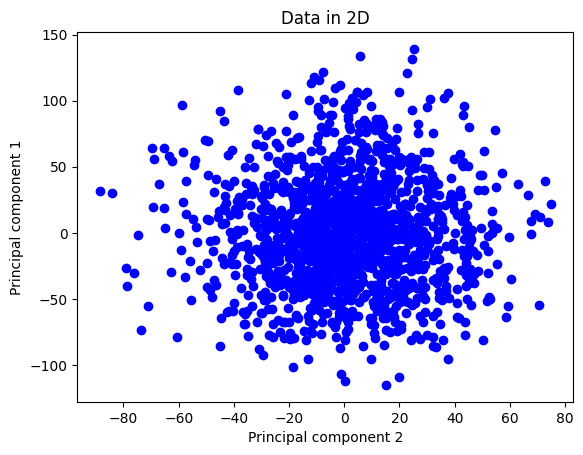

In [9]:
W_2d = eigenvectors[:, :2]
X_train_2d = X_train_std.dot(W_2d)
plt.scatter(X_train_2d[:, 1], X_train_2d[:, 0], c='blue')
plt.title('Data in 2D')
plt.ylabel('Principal component 1')
plt.xlabel('Principal component 2')
plt.show()

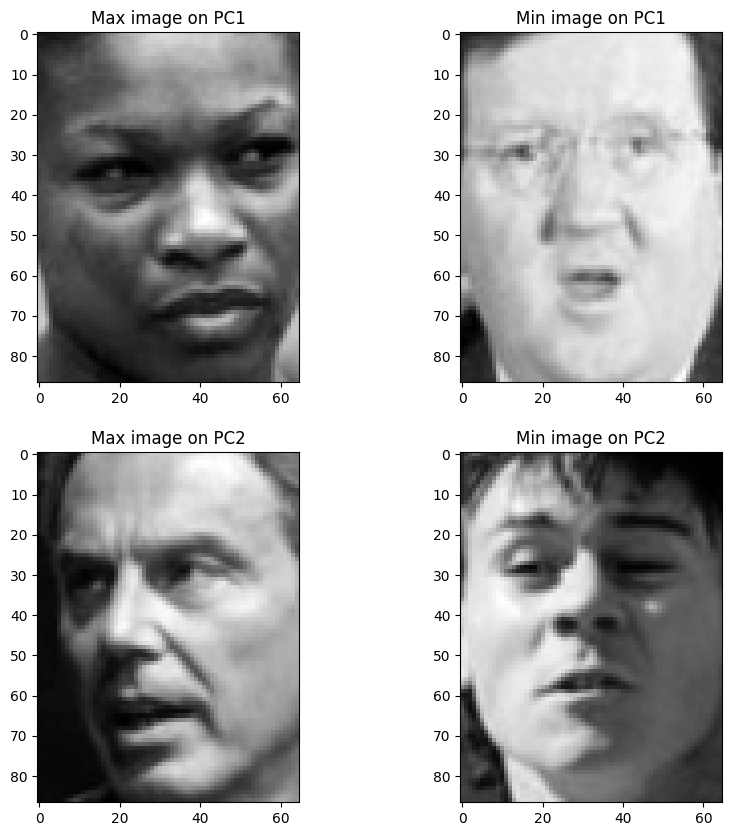

The max image on PC1 corresponds to the face of Serena Williams
The min image on PC1 corresponds to the face of George Robertson
The max image on PC2 corresponds to the face of Tony Blair
The min image on PC2 corresponds to the face of Guillermo Coria


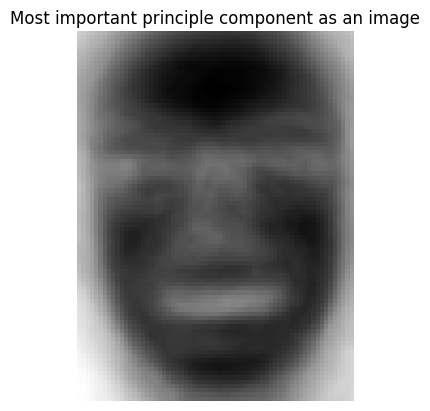

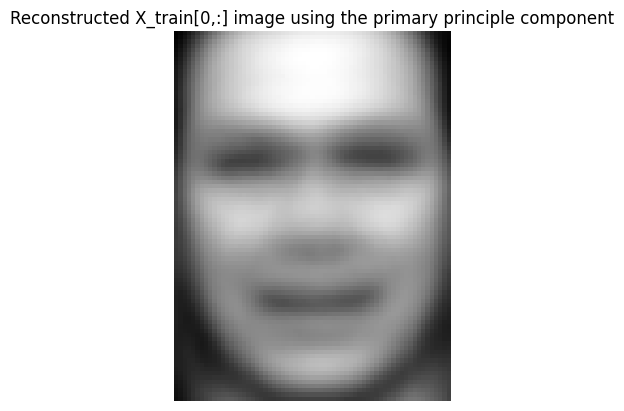

Number of principal components necessary to encode at least 95% of the information: 203


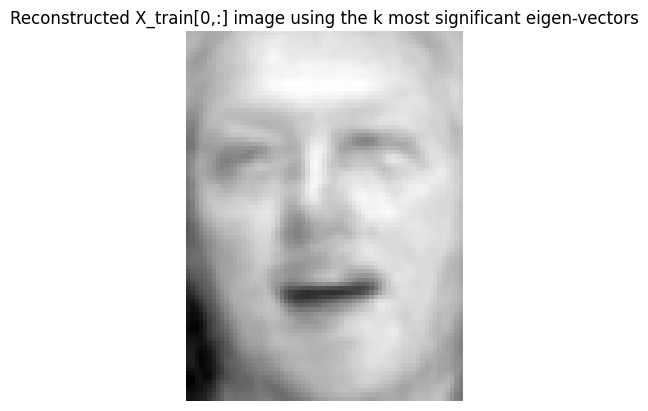

In [10]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X = (X_train - mean) / std

covariance_matrix = np.cov(X.T)
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

pc1 = eigenvectors[:, 0]
pc2 = eigenvectors[:, 1]

X_train_proj = np.dot(X, eigenvectors[:, :2])

max_pc1_idx = np.argmax(X_train_proj[:, 0])
min_pc1_idx = np.argmin(X_train_proj[:, 0])
max_pc2_idx = np.argmax(X_train_proj[:, 1])
min_pc2_idx = np.argmin(X_train_proj[:, 1])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(X_train[max_pc1_idx].reshape(image_shape), cmap=cm.gray)
axes[0, 0].set_title("Max image on PC1")
axes[0, 1].imshow(X_train[min_pc1_idx].reshape(image_shape), cmap=cm.gray)
axes[0, 1].set_title("Min image on PC1")
axes[1, 0].imshow(X_train[max_pc2_idx].reshape(image_shape), cmap=cm.gray)
axes[1, 0].set_title("Max image on PC2")
axes[1, 1].imshow(X_train[min_pc2_idx].reshape(image_shape), cmap=cm.gray)
axes[1, 1].set_title("Min image on PC2")
plt.show()

print("The max image on PC1 corresponds to the face of", people.target_names[y_train[max_pc1_idx]])
print("The min image on PC1 corresponds to the face of", people.target_names[y_train[min_pc1_idx]])
print("The max image on PC2 corresponds to the face of", people.target_names[y_train[max_pc2_idx]])
print("The min image on PC2 corresponds to the face of", people.target_names[y_train[min_pc2_idx]])


most_important_pc = eigenvectors[:, 0]
most_important_pc = (most_important_pc - np.min(most_important_pc)) / (np.max(most_important_pc) - np.min(most_important_pc))
most_important_pc_image = np.reshape(most_important_pc, (87, 65))
plt.imshow(most_important_pc_image, cmap=cm.gray)
plt.title('Most important principle component as an image')
plt.axis('off')
plt.show()


first_image = X[0,:]
reconstructed_image = np.dot(first_image, eigenvectors[:, 0]) * eigenvectors[:, 0]
reconstructed_image = reconstructed_image * np.std(X_train, axis=0) + np.mean(X_train, axis=0)
reconstructed_image = np.reshape(reconstructed_image, (87, 65))
fig, ax = plt.subplots()
ax.imshow(reconstructed_image, cmap=cm.gray)
ax.axis('off')
ax.set_title('Reconstructed X_train[0,:] image using the primary principle component')
plt.show()

total_var = np.sum(eigenvalues)
var_percentage = eigenvalues/total_var
cumulative_var_percentage = np.cumsum(var_percentage)
k = np.argmax(cumulative_var_percentage >= 0.95) + 1
print("Number of principal components necessary to encode at least 95% of the information:", k)

k_eigenvectors = eigenvectors[:, :k]
reconstructed_image_k = np.dot(first_image, k_eigenvectors) @ k_eigenvectors.T
reconstructed_image_k = reconstructed_image_k * np.std(X_train, axis=0) + np.mean(X_train, axis=0)
reconstructed_image_k = np.reshape(reconstructed_image_k, (87, 65))
fig, ax = plt.subplots()
ax.imshow(reconstructed_image_k, cmap=cm.gray)
ax.set_title('Reconstructed X_train[0,:] image using the k most significant eigen-vectors')
ax.axis('off')
plt.show()